In [1]:
import os

import h5py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scportrait.pipeline.featurization import CellFeaturizer
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose
from scportrait.pipeline.selection import LMDSelection

/Users/sophia/mambaforge/envs/scportrait_test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_location = "project"

project = Project(
    os.path.abspath(project_location),
    config_path="config_example4.yml",
    overwrite=True,
    debug=True,
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    featurization_f=CellFeaturizer,
    selection_f=LMDSelection,
)

Updating project config file.
[27/02/2025 18:14:39] Loading config from /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_4/project/config.yml
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_4/project/scportrait
         .sdata                                                                                                    
[27/02/2025 18:14:39] Compression algorithm for extracted single-cell images: lzf
[27/02/2025 18:14:39] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_4.
[27/02/2025 18:14:39] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_4.


In [3]:
from scportrait.data._datasets import dataset_4

dataset_4_path = dataset_4()

# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = [f"{dataset_4_path}/Ch1.tif", f"{dataset_4_path}/Ch2.tif", f"{dataset_4_path }/Ch3.tif"]

project.load_input_from_tif_files(images)

Downloading...: 100%|██████████| 5.90M/5.90M [00:01<00:00, 5.65MB/s]


[27/02/2025 18:14:41] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_4/Project_bysgzgzn for Project
[27/02/2025 18:14:41] Image input_image written to sdata object.
[27/02/2025 18:14:41] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_4/Project_bysgzgzn'>


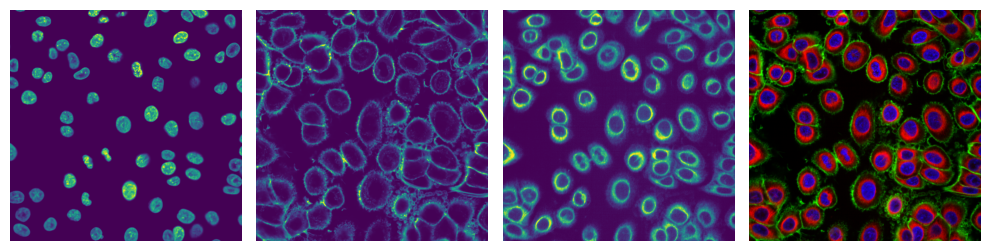

In [ ]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

from scportrait.plotting.vis import generate_composite

fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(project.input_image[0])
axs[0].axis("off")

axs[1].imshow(project.input_image[1])
axs[1].axis("off")

axs[2].imshow(project.input_image[2])
axs[2].axis("off")

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off")

fig.tight_layout()

[27/02/2025 18:14:43] GPU Status for segmentation is True and will segment using the following device mps.
[27/02/2025 18:14:43] Segmenting nucleus using the following model: nuclei
[27/02/2025 18:14:49] Segmenting cytosol using the following model: cyto2
[27/02/2025 18:15:10] Performing filtering to match Cytosol and Nucleus IDs.
[27/02/2025 18:15:11] Removed 14 nuclei and 4 cytosols due to filtering.
[27/02/2025 18:15:11] After filtering, 41 matching nuclei and cytosol masks remain.
[27/02/2025 18:15:14] Total time to perform nucleus and cytosol mask matching filtering: 3.12 seconds
[27/02/2025 18:15:14] Segmentation seg_all_nucleus written to sdata object.
[27/02/2025 18:15:15] Points centers_seg_all_nucleus written to sdata object.
[27/02/2025 18:15:15] Segmentation seg_all_cytosol written to sdata object.
[27/02/2025 18:15:15] Points centers_seg_all_cytosol written to sdata object.


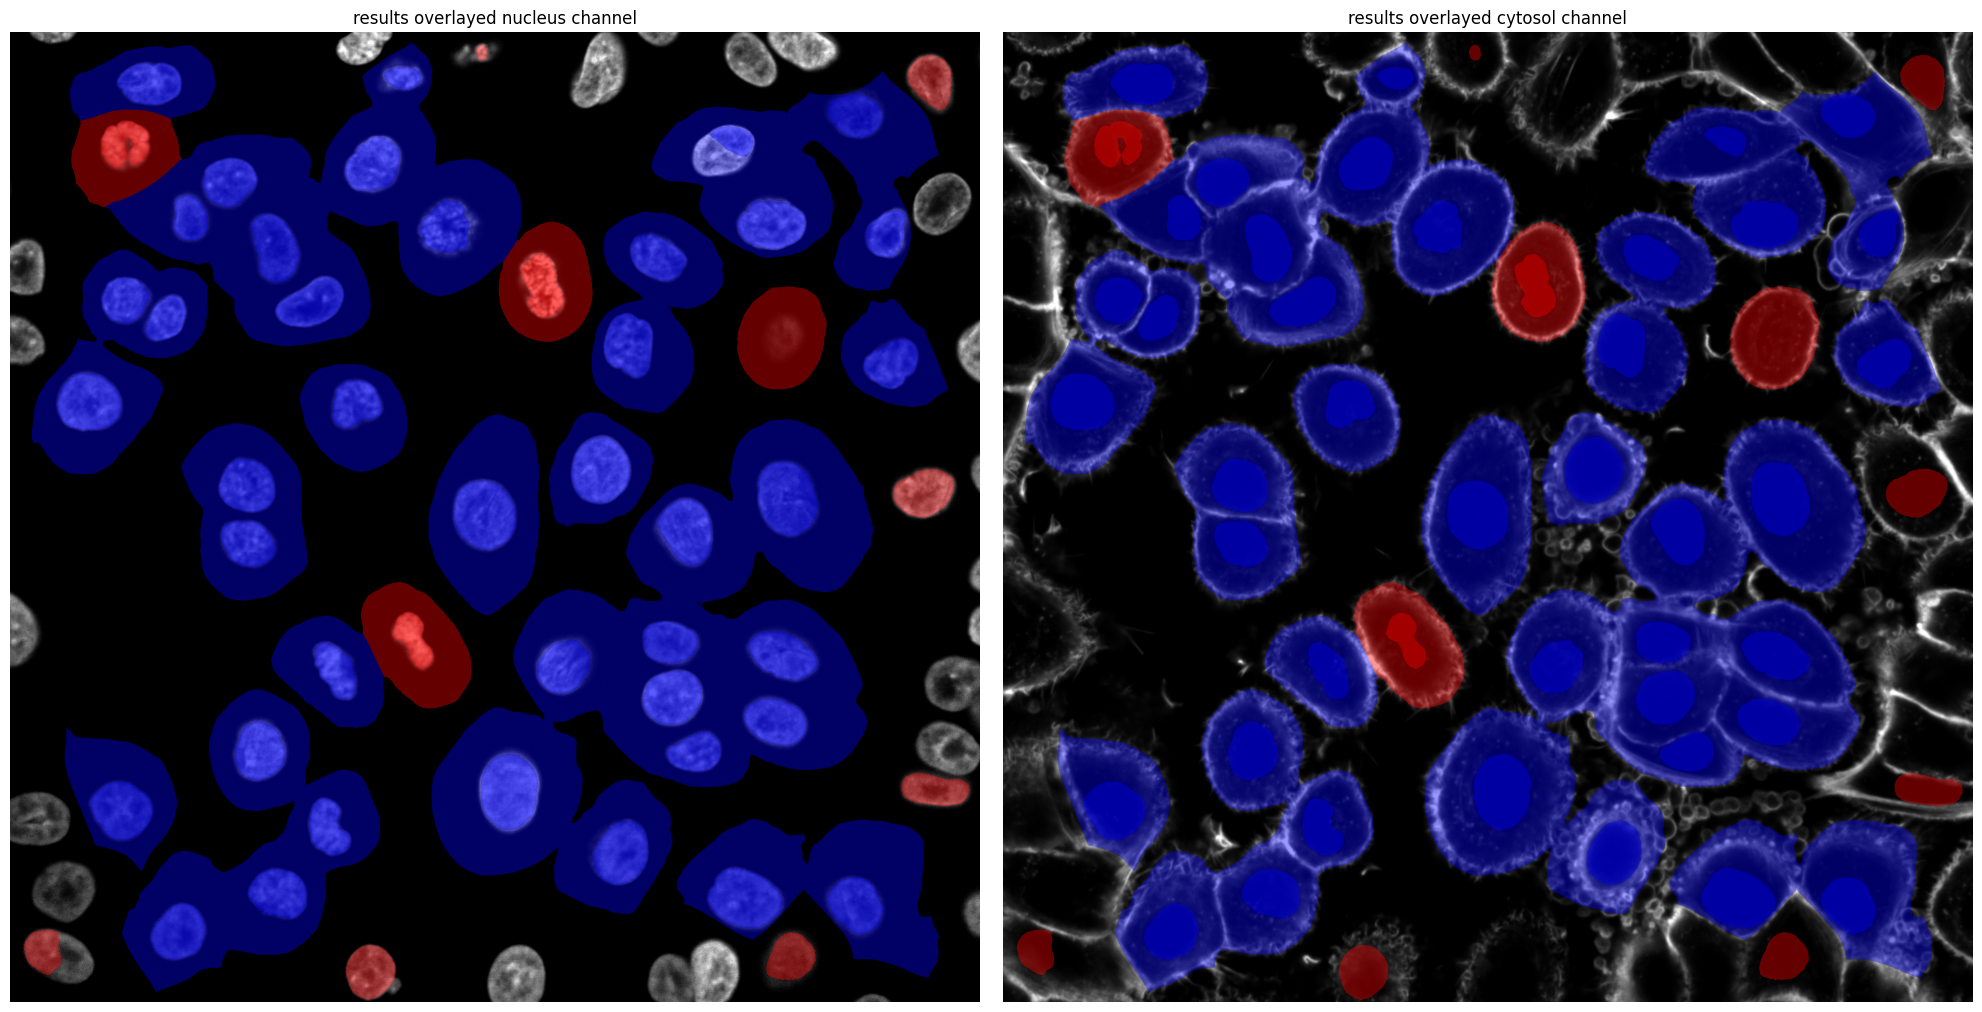

In [5]:
project.segment()

(-0.5, 2158.5, 2158.5, -0.5)

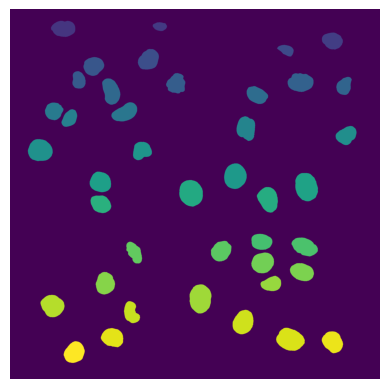

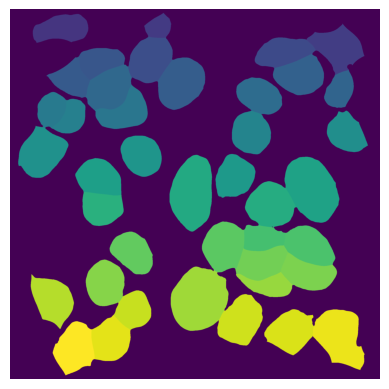

In [6]:
plt.figure()
plt.imshow(project.sdata["seg_all_nucleus"])
plt.axis("off")

plt.figure()
plt.imshow(project.sdata["seg_all_cytosol"])
plt.axis("off")

In [7]:
project.extract()

[27/02/2025 18:15:20] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/HDF5CellExtraction_2hqrjr0f for HDF5CellExtraction
[27/02/2025 18:15:20] Created new directory for extraction results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_4/project/extraction/data
[27/02/2025 18:15:20] Setup output folder at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_4/project/extraction/data
[27/02/2025 18:15:20] Found 2 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_nucleus', 'seg_all_cytosol']
[27/02/2025 18:15:20] Using seg_all_nucleus as the main segmentation mask to determine cell centers.
[27/02/2025 18:15:20] A total of 6 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_4/pro

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


[27/02/2025 18:15:21] Finished extraction in 0.89 seconds (39.50 cells / second)
[27/02/2025 18:15:21] Benchmarking times saved to file.
[27/02/2025 18:15:21] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/HDF5CellExtraction_2hqrjr0f'>


(35, 5, 400, 400)


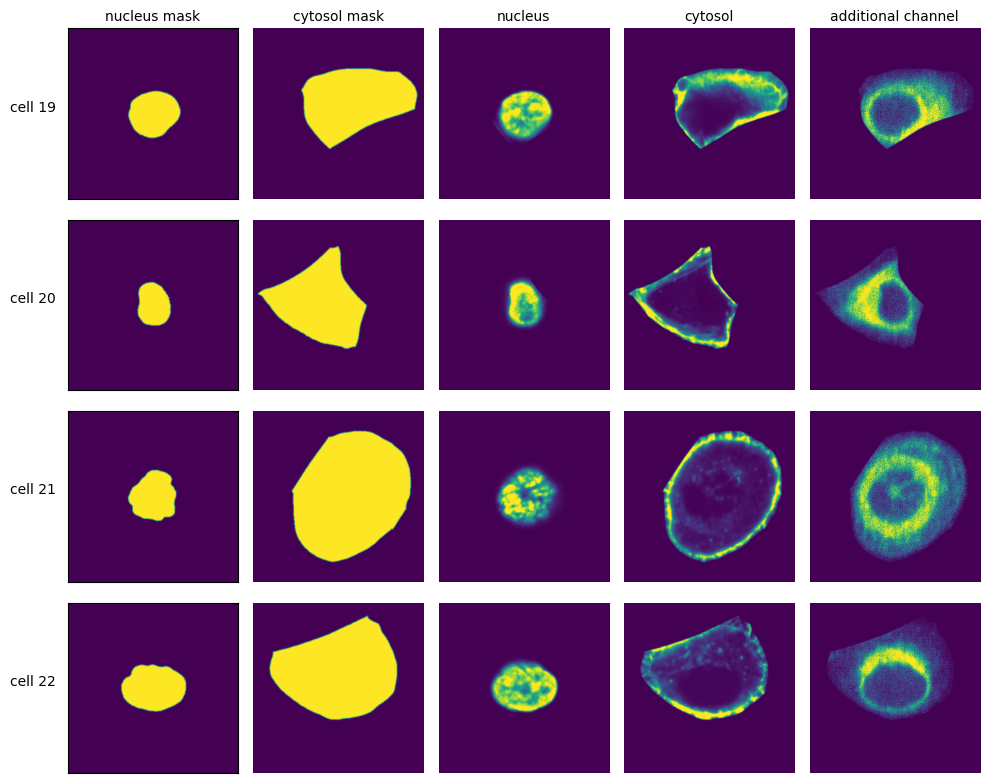

In [8]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 5, figsize=(5 * 2, len(n_cells) * 2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img, vmin=0, vmax=1)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()

In [9]:
project.featurize()

Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_4/project/extraction/data/single_cells.h5
[27/02/2025 18:15:22] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_4/CellFeaturizer_ks3f_uv1 for CellFeaturizer
[27/02/2025 18:15:22] Started CellFeaturization of all available channels.
[27/02/2025 18:15:22] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_4/project/featurization/complete_CellFeaturizer
[27/02/2025 18:15:22] Automatically configured inference device to mps
[27/02/2025 18:15:22] Reading data from path: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_4/project/extraction/data/single_cells.h5
[27/02/2025 18:15:22] Dataloader generated with a batchsize of 900 and 10 workers. Dataloader contains 1 entries.
[27/02/2025 18:15

In [10]:
# load classification results
results = pd.read_csv(f"{project_location}/featurization/complete_CellFeaturizer/calculated_image_features.csv")
results

,nucleus_area,cytosol_area,cytosol_only_area,1_mean_nucleus,1_median_nucleus,1_quant75_nucleus,1_quant25_nucleus,1_summed_intensity_nucleus,1_summed_intensity_area_normalized_nucleus,1_mean_cytosol,...,3_summed_intensity_cytosol,3_summed_intensity_area_normalized_cytosol,3_mean_cytosol_only,3_median_cytosol_only,3_quant75_cytosol_only,3_quant25_cytosol_only,3_summed_intensity_cytosol_only,3_summed_intensity_area_normalized_cytosol_only,label,cell_id
0,5619.0,47580.0,41961.0,0.060168,0.0,0.0,0.0,9626.8720,0.229424,0.060168,...,16804.5660,0.400481,0.105029,0.000000,0.093750,0.0,16804.5660,0.400481,0,16
1,13112.0,56716.0,43604.0,0.059105,0.0,0.0,0.0,9456.8180,0.216880,0.059105,...,17026.6480,0.390484,0.106417,0.000000,0.131836,0.0,17026.6480,0.390484,0,17
2,11820.0,37531.0,25711.0,0.052573,0.0,0.0,0.0,8411.6875,0.327163,0.052573,...,14127.2850,0.549465,0.088296,0.000000,0.000000,0.0,14127.2850,0.549465,0,19
3,7744.0,36103.0,28359.0,0.034812,0.0,0.0,0.0,5569.8660,0.196406,0.034812,...,13219.0550,0.466133,0.082619,0.000000,0.000000,0.0,13219.0550,0.466133,0,20
4,11725.0,67705.0,55980.0,0.053333,0.0,0.0,0.0,8533.2630,0.152434,0.053333,...,27649.0430,0.493909,0.172807,0.000000,0.308838,0.0,27649.0430,0.493909,0,21
5,14879.0,53144.0,38265.0,0.067154,0.0,0.0,0.0,10744.6910,0.280797,0.067154,...,13805.5550,0.360788,0.086285,0.000000,0.087524,0.0,13805.5550,0.360788,0,22
6,8530.0,29924.0,21394.0,0.036203,0.0,0.0,0.0,5792.4033,0.270749,0.036203,...,10046.7320,0.469605,0.062792,0.000000,0.000000,0.0,10046.7320,0.469605,0,23
7,14002.0,55082.0,41080.0,0.059873,0.0,0.0,0.0,9579.7380,0.233197,0.059873,...,18558.1400,0.451756,0.115988,0.000000,0.138672,0.0,18558.1400,0.451756,0,24
8,11119.0,46629.0,35510.0,0.047743,0.0,0.0,0.0,7638.9033,0.215120,0.047743,...,13630.0450,0.383837,0.085188,0.000000,0.050629,0.0,13630.0450,0.383837,0,25
9,13442.0,47968.0,34526.0,0.050341,0.0,0.0,0.0,8054.6350,0.233292,0.050341,...,16565.4260,0.479796,0.103534,0.000000,0.061737,0.0,16565.4260,0.479796,0,28


Text(0.5, 0, 'cytosol area')

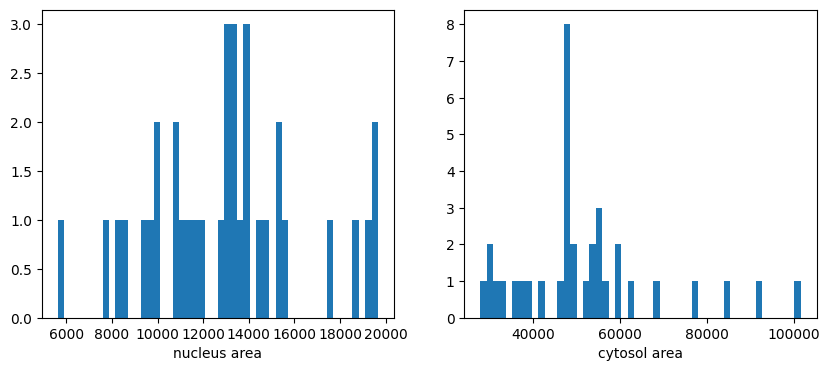

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(results["nucleus_area"], bins=50)
axs[0].set_xlabel("nucleus area")

axs[1].hist(results["cytosol_area"], bins=50)
axs[1].set_xlabel("cytosol area")